In [3]:
# !pip install ipywidgets

In [9]:
import os
import warnings
import numpy as np
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit
import seaborn as sb
import matplotlib.pyplot as plt
import pvl
import ray

warnings.filterwarnings("ignore", message="Could not find isis. Is `ISISROOT` set?")
from pysis import CubeFile



In [10]:
## Access files

def fetch_d_from_lbl(filepath):
    with open(filepath, 'r') as file:
        lbl_data = pvl.load(file)

    d_km = float(lbl_data['SPACECRAFT_SOLAR_DISTANCE'][0])
    d_au = d_km / 149597870.7
    
    return d_au


def mk_data_dict(directory):
    all_files = [file for file in os.listdir(directory)]
    if len(all_files) == 0:
        return print("The directory is empty.")
    else:
        cubefiles_dict = {}
        for file in all_files:
            if file.endswith('.cub') and '_phodata' not in file:
                base_name = file.replace('.cub', '')

                denoise_iof_file = f"{base_name}_1_artifact_corrected.npy"
                denoised_directory = '/Data/sourav/Artifact_correction/Data/artifact-corrected/artifact-corrected-survey-ir-ceres-nasa-pds/'
                denoised_iof_file_path = os.path.join(denoised_directory, denoise_iof_file)

                lbl_file = f"{base_name}_1.LBL"
                lbl_file_path = os.path.join(directory, lbl_file)

                temp_emissivity_file = f"{base_name}_temp_emissivity.npy"
                temp_emissivity_file_path = os.path.join("/Data/soumik_backup/survey_1b/clark_2/", temp_emissivity_file)

                cubefiles_dict[base_name] = {
                    "lbl_file": lbl_file_path,
                    "iof_data": denoised_iof_file_path,
                    "temp_e_data": temp_emissivity_file_path,
                }
        if len(cubefiles_dict) == 0:
            print("No cubefiles detected in the provided repository.")
        else:
            print(str(len(cubefiles_dict)) + " files has been mapped.")

        return cubefiles_dict


def cubefile_to_numpy(imagefile):
    image = CubeFile.open(imagefile)
    image_datalist = image.apply_numpy_specials()
    return image_datalist



In [11]:
source_directory = '/Data/soumik_backup/'

data_directory = source_directory + 'survey_1b/cub_converted/'
save_directory = source_directory + 'survey_1b/clark_corrected/'

ss_data = np.loadtxt(source_directory+"ss-ceres-dawn.txt", delimiter='\t', skiprows=1)

wavelengths = ss_data[:, 0]
solar_flux =  ss_data[:, 1]

vir_corr_factor = np.loadtxt(source_directory+'VIR_correction_factor_IR.txt', delimiter=',', skiprows=1)

survey_dict = mk_data_dict(data_directory)
keys = [key for key in survey_dict.keys()]


183 files has been mapped.


In [12]:
def blackbody_rad(wav,T):
    c1 = 3.74177*(10**-16)          #2*const.pi*const.h*(const.c**2)            #3.7417718521927573e-16
    c2 = 0.014387774                #const.c*const.h/const.Boltzmann            #0.014387768775039337

    radiance= ((c1/((wav/(10**6))**5))*(1/(np.exp(c2/((wav*T)/(10**6)))-1)))/((10**6)*np.pi)
    return radiance


In [18]:
ray.init(ignore_reinit_error=True, num_cpus=30)

@ray.remote
def process_key(key, survey_dict, wavelengths, solar_flux, save_directory):
    print(f"Processing key: {key}")

    iof_image = np.load(survey_dict[key]['iof_data'])
    d_au = fetch_d_from_lbl(survey_dict[key]['lbl_file'])

    clark_result = np.load(survey_dict[key]['temp_e_data'], allow_pickle=True).item()
    temp = clark_result['fitted_temp']
    emissivity = clark_result['fitted_emissivity']
    temp_error = clark_result['temp_error']
    emissivity_error = clark_result['emissivity_error']

    thermal_rad = np.zeros(iof_image.shape)
    thermal_ref = np.zeros(iof_image.shape)

    for i in range(iof_image.shape[1]):
        for j in range(iof_image.shape[2]):
            thermal_rad[:, i, j] = emissivity[i, j] * blackbody_rad(wavelengths, temp[i, j])
            thermal_ref[:, i, j] = thermal_rad[:, i, j] * np.pi * d_au**2 / solar_flux

    corrected_spectra = iof_image - thermal_ref

    filepath = f"{save_directory}{key}_clark_corrected.npy"
    np.save(filepath, corrected_spectra)
    print(f"Saved corrected spectra for key: {key} at {filepath}")

tasks = [process_key.remote(key, survey_dict, wavelengths, solar_flux, save_directory) for key in keys]

ray.get(tasks)

ray.shutdown()


2024-12-05 10:26:26,473	INFO worker.py:1821 -- Started a local Ray instance.


(process_key pid=487285) Processing key: VIR_IR_1B_1_486796696


(process_key pid=487285) /tmp/ipykernel_471585/3635446409.py:5: RuntimeWarning: divide by zero encountered in divide


(process_key pid=487285) Saved corrected spectra for key: VIR_IR_1B_1_486796696 at /Data/soumik_backup/survey_1b/clark_corrected/VIR_IR_1B_1_486796696_clark_corrected.npy


(process_key pid=487365) /tmp/ipykernel_471585/3635446409.py:5: RuntimeWarning: overflow encountered in exp


(process_key pid=487362) Processing key: VIR_IR_1B_1_488260769 [repeated 182x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(process_key pid=487365) Saved corrected spectra for key: VIR_IR_1B_1_488251455 at /Data/soumik_backup/survey_1b/clark_corrected/VIR_IR_1B_1_488251455_clark_corrected.npy [repeated 179x across cluster]


(process_key pid=487365) /tmp/ipykernel_471585/3635446409.py:5: RuntimeWarning: divide by zero encountered in divide [repeated 29x across cluster]


/tmp/ipykernel_471585/3635446409.py:5: RuntimeWarning: divide by zero encountered in divide
  radiance= ((c1/((wav/(10**6))**5))*(1/(np.exp(c2/((wav*T)/(10**6)))-1)))/((10**6)*np.pi)


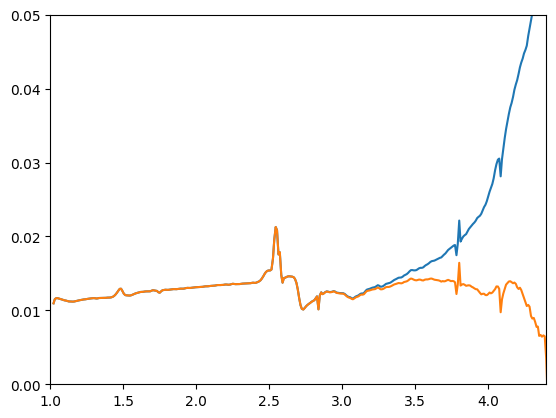

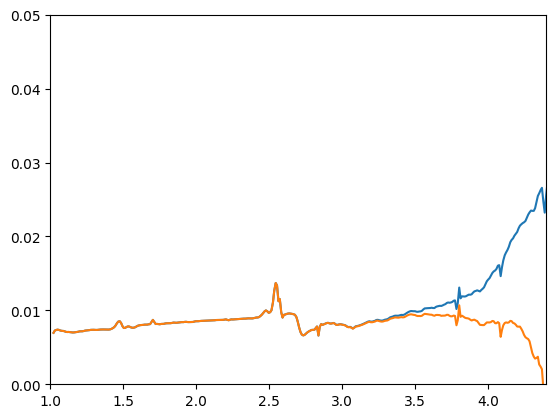

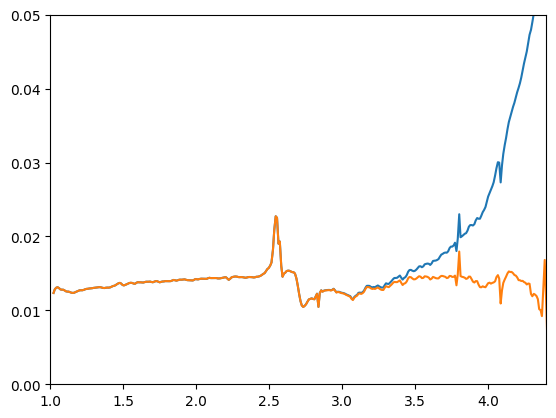

In [ ]:
# for key in keys[5:8]:
#     iof_image = np.load(survey_dict[key]['iof_data'])
#     d_au = fetch_d_from_lbl(survey_dict[key]['lbl_file'])

#     clark_result = np.load(survey_dict[key]['temp_e_data'], allow_pickle=True).item()
#     temp = clark_result['fitted_temp']
#     emissivity = clark_result['fitted_emissivity']
#     temp_error = clark_result['temp_error']
#     emissivity_error = clark_result['emissivity_error']

#     thermal_rad = np.zeros(iof_image.shape)
#     thermal_ref = np.zeros(iof_image.shape)

#     for i in range(iof_image.shape[1]):
#         for j in range(iof_image.shape[2]):
#             thermal_rad[:, i, j] = emissivity[i, j] * blackbody_rad(wavelengths, temp[i, j])
#             thermal_ref[:, i, j] = thermal_rad[:, i, j] * np.pi * d_au**2 / solar_flux

#     corrected_image = iof_image - thermal_ref

#     plt.plot(wavelengths, iof_image[:, 25, 120])
#     plt.plot(wavelengths, corrected_image[:, 25, 120])
#     plt.xlim(1, 4.4)
#     plt.ylim(0, 0.05)
#     plt.show()